## Лекція 46. Побудова прогнозів

## Завдання:

#### Використовуючи датасет з файлу cardox.csv (об’єми продажів мережі супермаркетів) виконайте наступну роботу:

1. Проведіть попередній аналіз даних
2. Скорегуйте виявлені аномалії
3. Проведіть необхідні попередні підготовки даних (декомпозиція, коригування ряду, заповнення пропущених значень і. т. і.)
4. Оберіть модель і проведіть оцінку її метрик
5. Проведіть кінцеву діагностику для отриманої моделі
6. Виконайте прогноз на 30 років
7. Збережіть результати прогнозування у файл

## Розв'язок:

### 1. Проводимо попередній аналіз даних

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adtk.visualization import plot
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Функція для побудови графіків сезонності

def sesonal(data, s):
    plt.figure(figsize=(20,20), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="right")
    plt.show()

In [3]:
# Завантажуємо наші дані

data = pd.read_csv('cardox.csv', parse_dates=True, index_col="date")
data.head()

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


In [4]:
# Інформація про наш датасет - пропущених даних немає

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 1958-03-01 to 2018-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   729 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [5]:
data.describe()

,value
count,729.000000
mean,353.787229
std,27.547500
min,312.660000
25%,328.570000
50%,351.410000
75%,375.990000
max,411.240000


[<AxesSubplot: >]

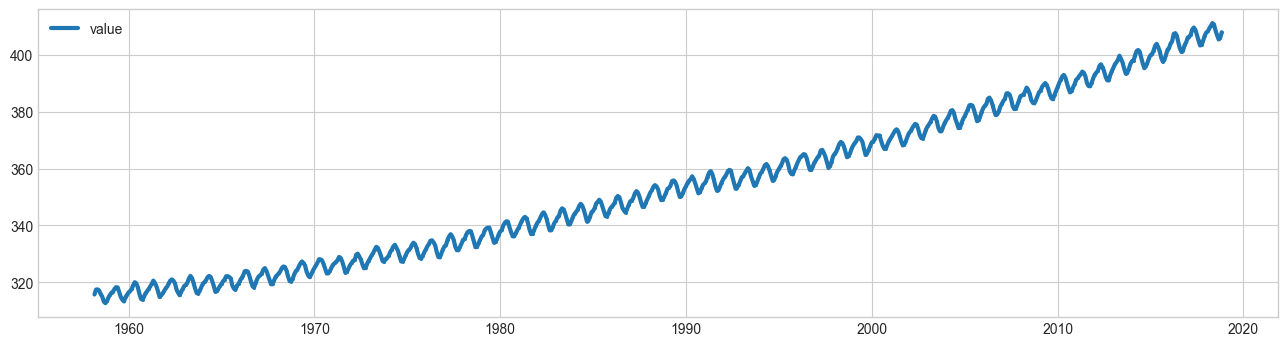

In [8]:
# Візуалізуємо наш датасет

plot(data, ts_linewidth=3)

#### Маємо яскраво виражений тренд та сезонність

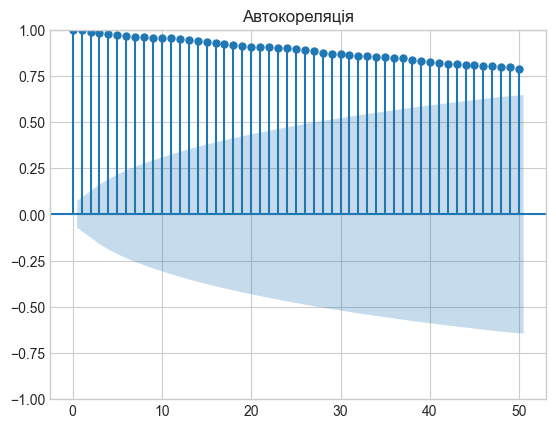

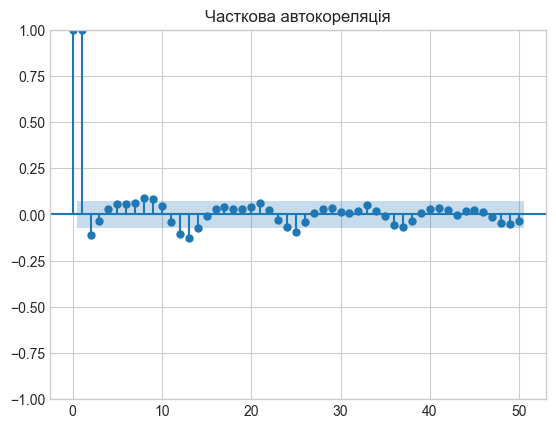

In [11]:
# Досліджуємо Автокореляцію та часткову автокореляцію

plot_acf(data, lags=50)
plt.title('Автокореляція')
plt.show()

plot_pacf(data, lags=50, method='ywm')
plt.title('Часткова автокореляція')
plt.show()

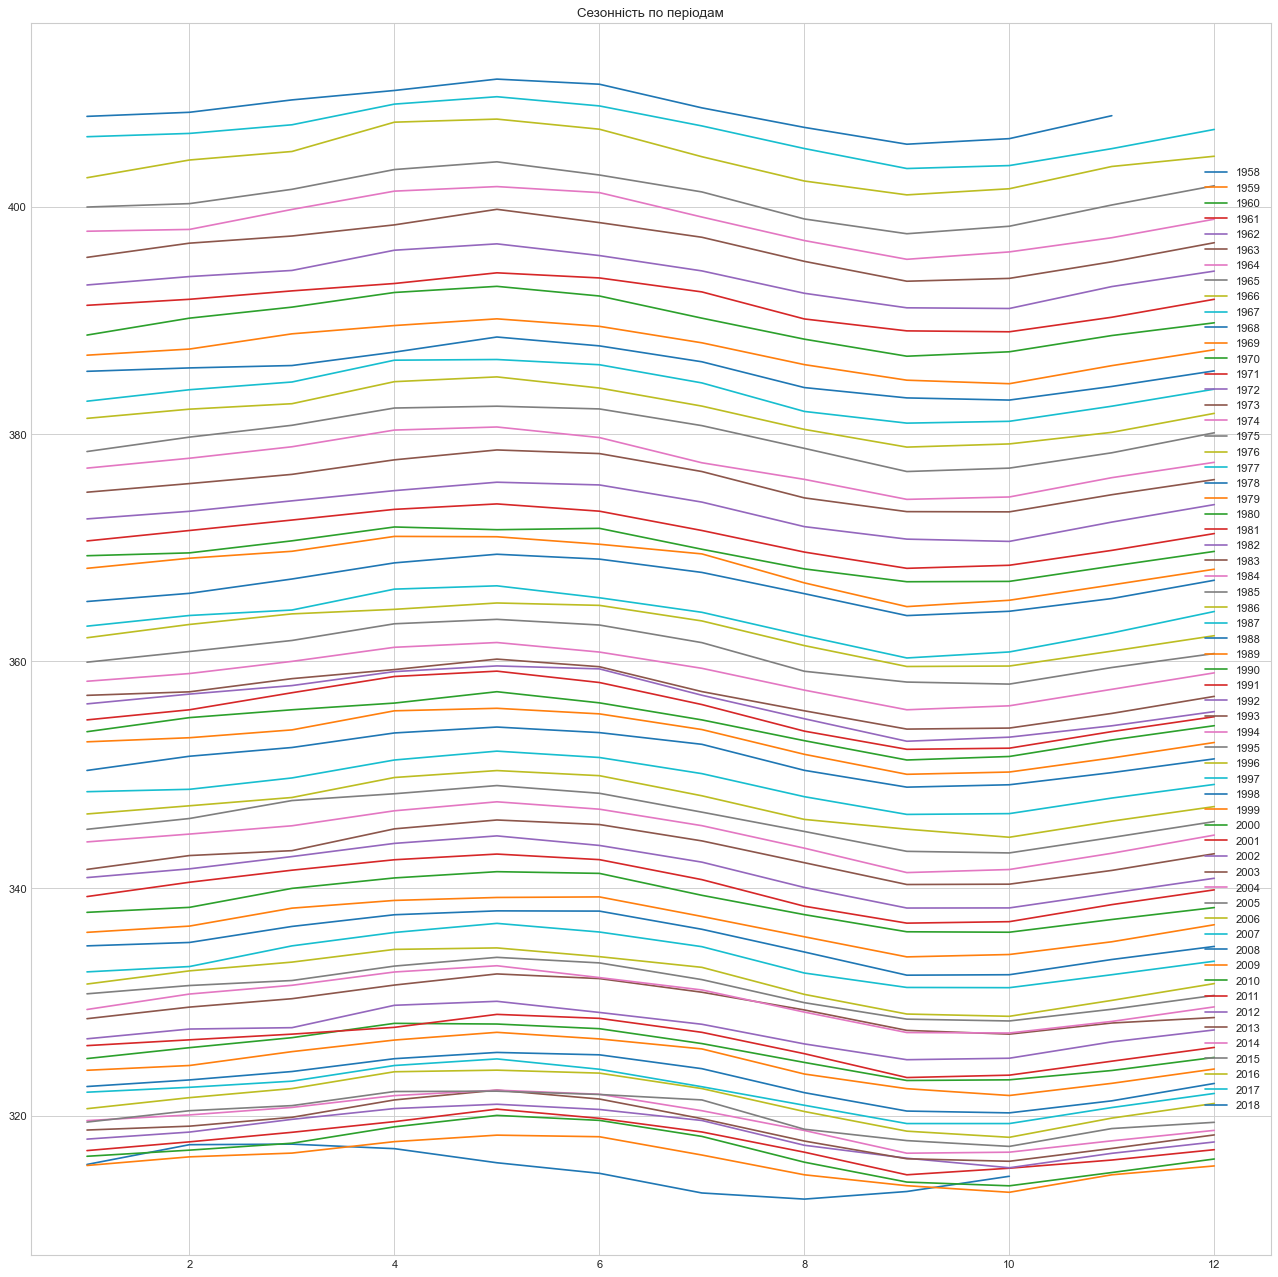

In [12]:
# Досліджуємо сезонність
sesonal(data,12)

# Бачимо яскраво виражену сезонність

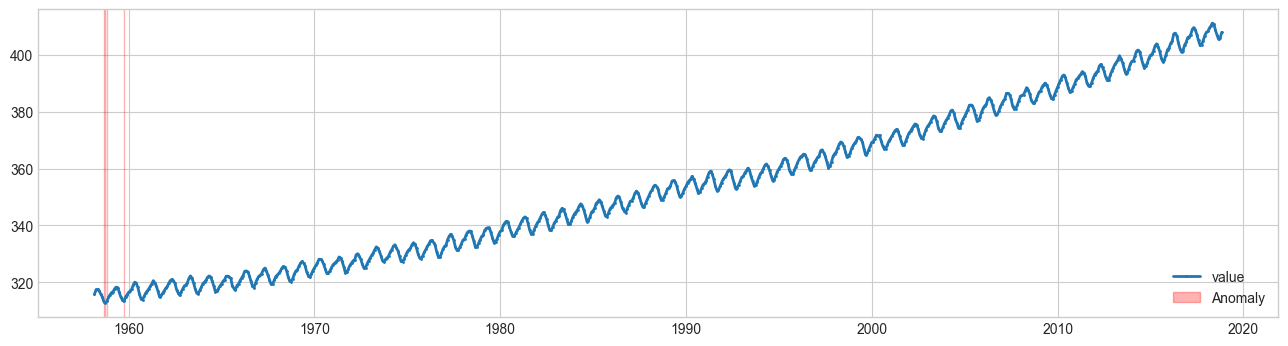

In [17]:
# Для виділення областей з аномальними даними можемо використати наступну функцію

outlier_detector = OutlierDetector(LocalOutlierFactor())
anomalies = outlier_detector.fit_detect(data)
plot(data, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

In [18]:
# Ці аномальні значення виводимо у вигляді таблиці

anomalies[anomalies]

date
1958-09-01    True
1958-10-01    True
1958-11-01    True
1959-10-01    True
dtype: bool

### 2. Корегуємо виявлені аномалії

In [19]:
anomalies[anomalies].count()

4

In [20]:
# Щоб уникнути аномалії з даними за 1958-1959 рік, замінюємо їх на аналогічні за 1960 рік
data.loc['1958-09-01']=data.loc['1960-09-01']
data.loc['1958-10-01']=data.loc['1960-10-01']
data.loc['1958-11-01']=data.loc['1960-11-01']
data.loc['1959-10-01']=data.loc['1960-10-01']

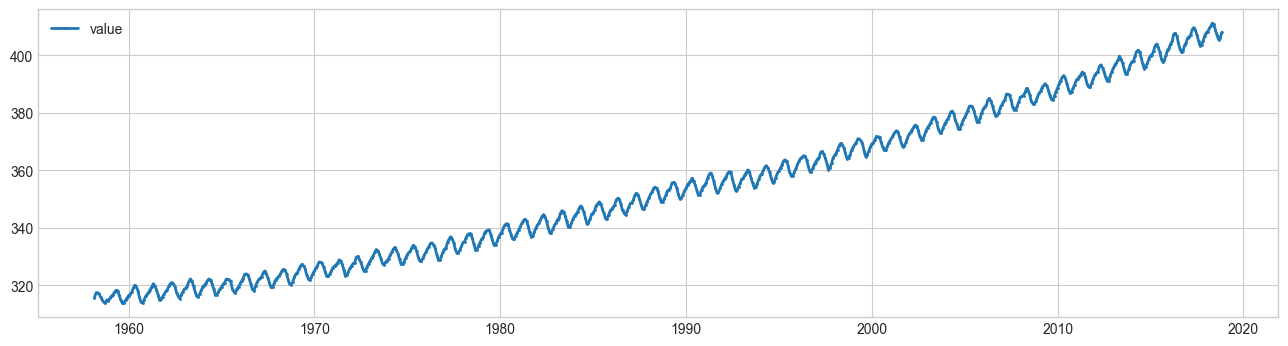

In [21]:
# Для виділення областей з аномальними даними можемо використати наступну функцію

outlier_detector = OutlierDetector(LocalOutlierFactor())
anomalies = outlier_detector.fit_detect(data)
plot(data, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

### 3. Проводимо необхідні попередні підготовки даних (декомпозиція, коригування ряду, заповнення пропущених значень і. т. п.)

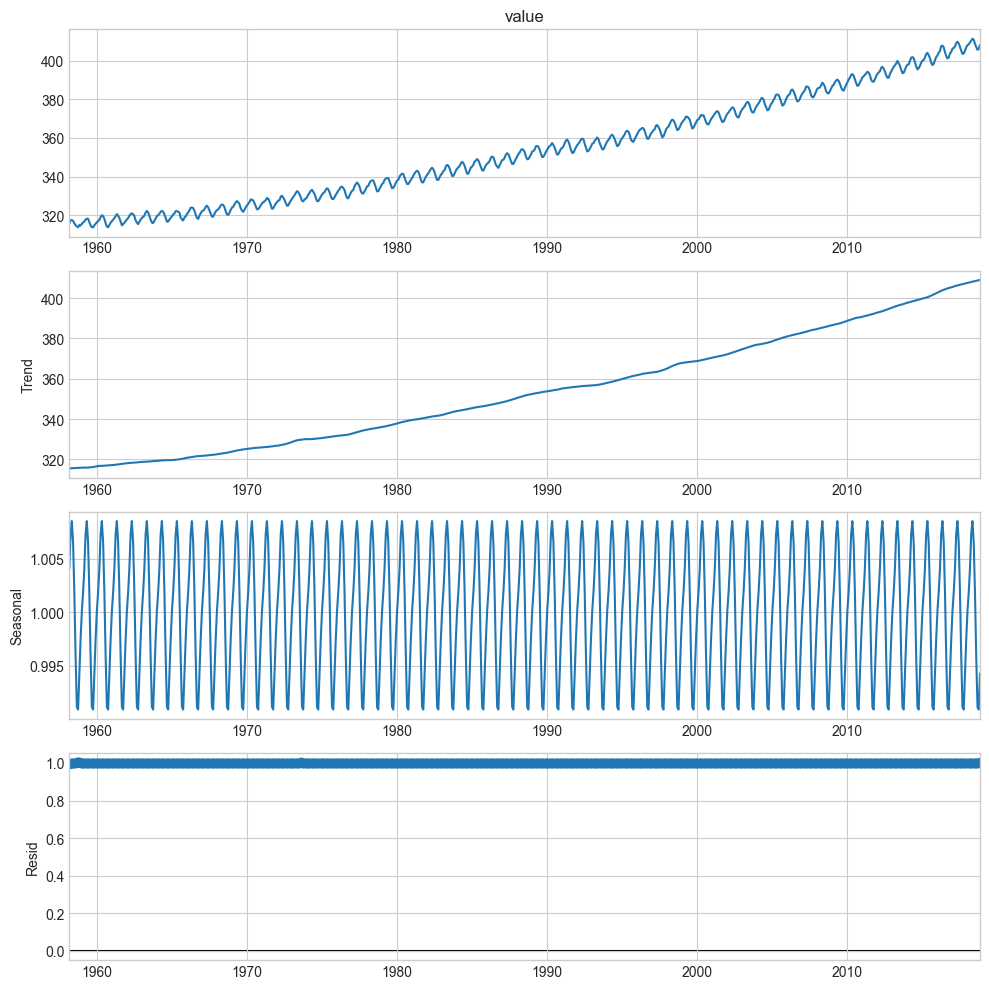

In [24]:
# Мультиплікатива Декомпозиція 
# Для проведення декомпозиції використаємо функцію seasonal_decompose

result_M = seasonal_decompose(data.value, model='multiplicative', extrapolate_trend=12)
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('');

In [25]:
data['value'].isna().sum()

0

Пропущених значень не виявлено

### 4. Обираємо модель і проведимо оцінку її метрик

In [26]:
# Знайдемо оптимальні значення параметрів ARIMA моделі

model = auto_arima(data.value, seasonal=True,
                   stepwise=True, trace=True, m=12)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=517.736, Time=2.68 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2366.134, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1613.912, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2371.885, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1106.432, Time=2.70 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=770.431, Time=3.00 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=492.828, Time=8.38 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=621.922, Time=6.85 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=8.87 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=539.132, Time=7.18 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=487.623, Time=5.66 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=482.261, Time=2.61 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=1493.947, Time=0.76 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept  

#### Best model:  ARIMA(2,1,1)(1,0,1)[12]  

In [29]:
# Ділимо наш датасет на навчальну і тренувальну частину
train = data.iloc[:-12]
test = data.iloc[-12:]

# Тренуємо нашу модель
model = ARIMA(train['value'], order=(2,1,1), seasonal_order=(1,0,1,12))
model_fit = model.fit()

In [30]:
# Робимо прогноз для тестового періоду

forecast = model_fit.forecast(len(test), alpha=0.05)

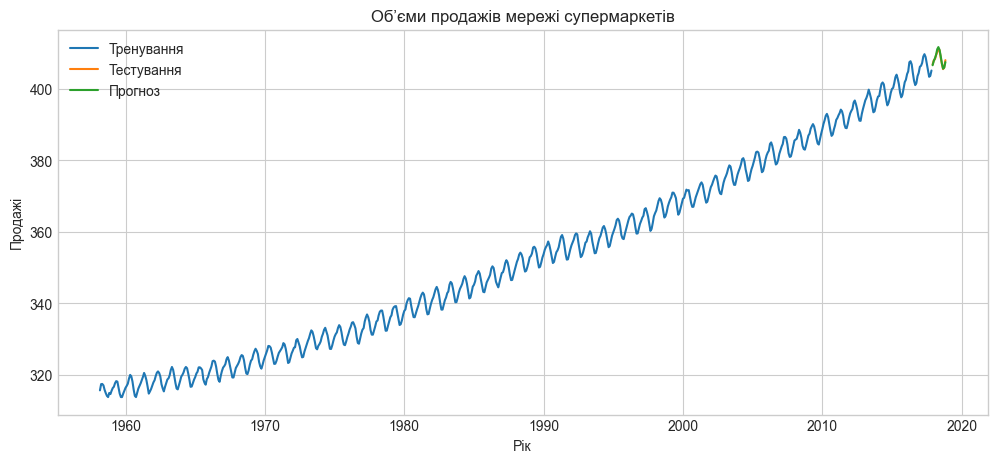

In [31]:
# Візуалізація прогнозу та реальних значень

plt.figure(figsize=(12,5))
plt.plot(train.index,train['value'], label='Тренування')
plt.plot(test.index,test['value'], label='Тестування')
plt.plot(test.index,forecast, label='Прогноз')
plt.xlabel('Рік')
plt.ylabel('Продажі')
plt.title('Об’єми продажів мережі супермаркетів')
plt.legend()
plt.show()

### 5. Проводимо кінцеву діагностику для отриманої моделі

In [34]:
# Обчислюємо метрики
mae = mean_absolute_error(test['value'], forecast)
rmse = np.sqrt(mean_squared_error(test['value'], forecast))

print('MAE:', mae)
print('MSE:', rmse)

MAE: 0.2829243026703902
MSE: 0.3641269104743078


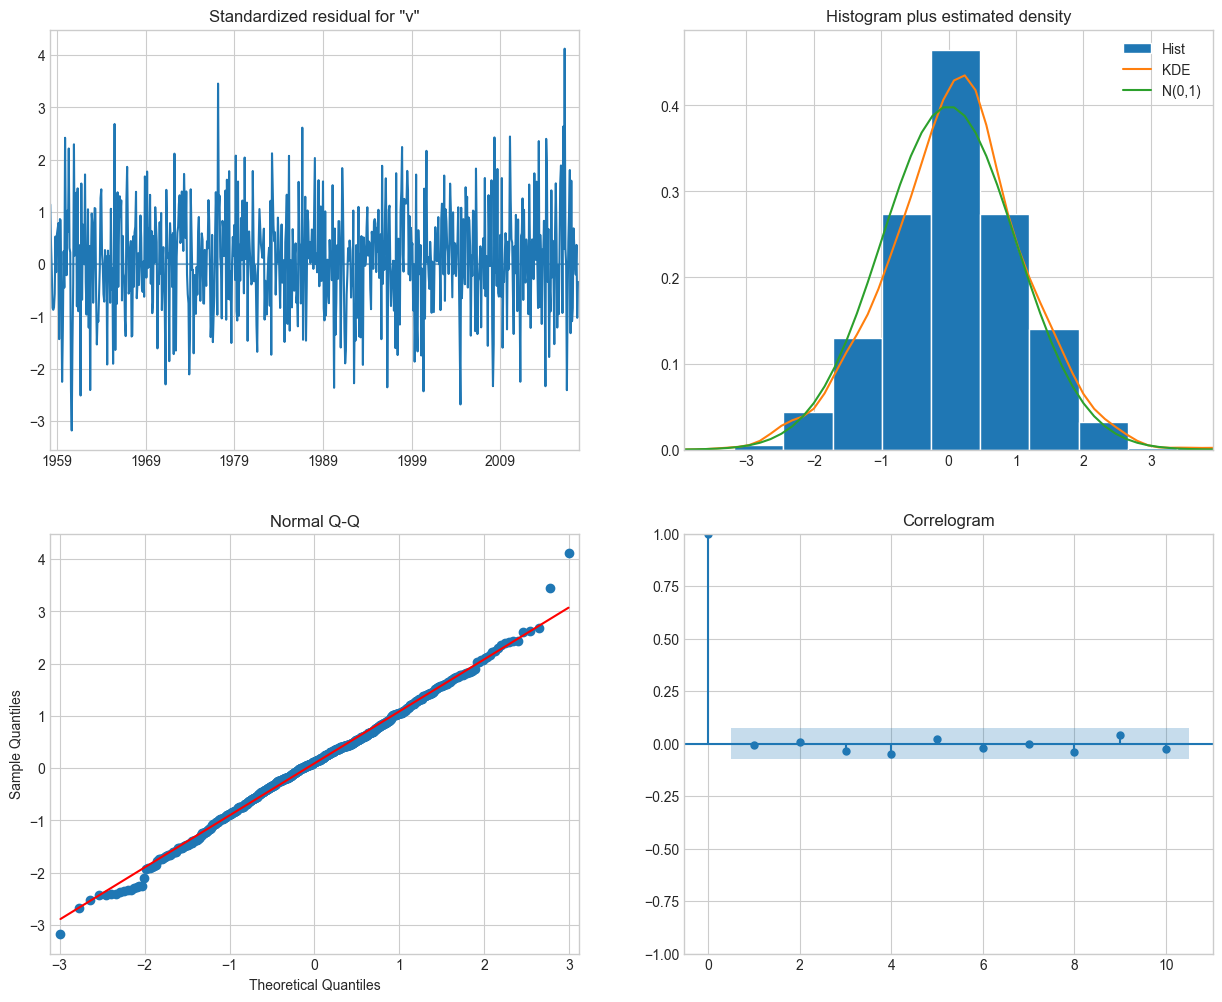

In [35]:
# Оцінюємо результати по діаграмам

model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

Як показують метрики та графіки, наша модель є достатньо точною і має давати досить точні прогнози.

### 6. Виконуємо прогноз на 30 років

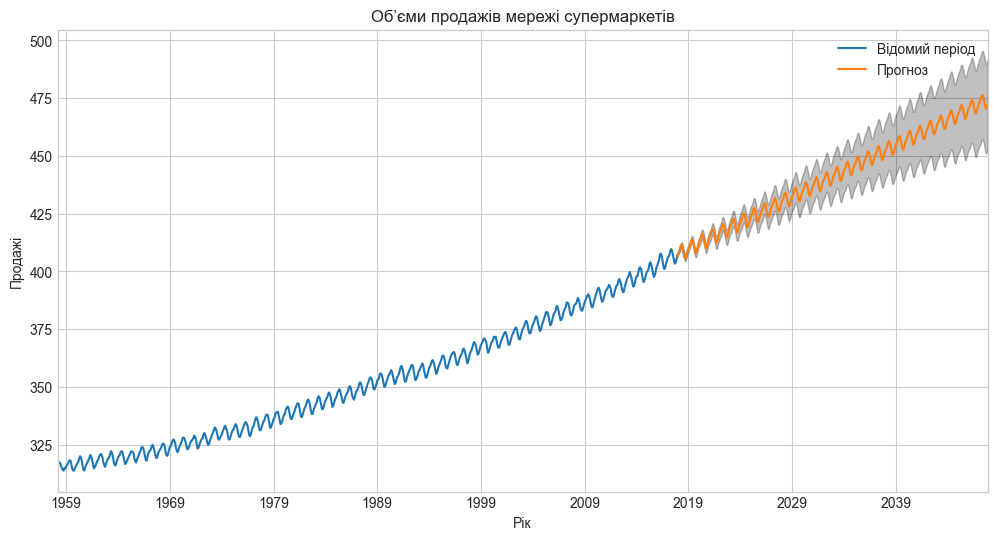

In [36]:
# Прогнозуємо значення на 30 років вперед

pred_uc = model_fit.get_forecast(steps=30*12)
pred_ci = pred_uc.conf_int()

ax = data['value'].plot(label='Відомий період', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Прогноз')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Рік')
ax.set_ylabel('Продажі')
ax.set_title('Об’єми продажів мережі супермаркетів')
plt.legend()
plt.show()

### 7. Зберігаємо результати прогнозування у файл

In [37]:
predict_df = pd.DataFrame({'Predict': pred_uc.predicted_mean,
                           'Low': pred_ci['lower value'],
                           'Up': pred_ci['upper value']})
predict_df.to_excel('Result_forecast_30yrs.xlsx')